In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray import DataArray
import pandas as pd
from PyEMD import EEMD
import pylab as plt
from scipy.stats import pearsonr

In [2]:
f = np.load("/work/uo1075/u241321/data//NAO_DJF_hind80.npy")

mode = 4+1 # mode(input, c1-c4)
time = 50
hind_eemd_9 = np.zeros((5,50)) # mode(input, c1-c4), station, time, lead year


In [13]:
f.shape

(50, 10)

In [3]:
# EEMD options
max_imf=3
# Prepare and run EEMD
eemd = EEMD(trials=10000, FIXE_H=10, DTYPE=np.float16, noise_width=0.2, parallel=True)   #max_imfs=10) parallel=True
eemd.noise_seed(6021)

t = np.arange(1970,2020,1)

In [4]:
hind_eemd_9[0,:] = f[:,0]

In [5]:
# Execute EEMD on ASSIM
hind_eemd_9[1::,:] = eemd.eemd(hind_eemd_9[0,:], t, max_imf)  
        

In [6]:
np.save("/work/uo1075/u241321/data/eemd_NAO_DJF_ly1_hind80", hind_eemd_9)

In [18]:
# Original script; with trend # result is almost same as the result of fft function
def rho(datax):
    # Calculates the lag-1 Autocorrelation Coefficient.
    import numpy as np  
    nrho=len(datax)
    sommesup=0
    sommeinf=0
    moy=np.sum(datax)/nrho
    datam=datax-moy
    for i in np.arange(1,nrho):
        j=i-1
        sommesup=sommesup+(datam[i]*datam[j])
        sommeinf=sommeinf+(datam[j]**2)
    rho=sommesup/sommeinf
    return rho

def rhoAlt(datax,dt=1):
    # Calculates the lag-dt Autocorrelation Coefficient, given the dt.
    import numpy as np  
    r=np.corrcoef(datax[0:-dt-1],datax[dt:-1])
    return r[0,1]

def rednoise(lenx, rho, nsim=1000, dist='normal', returnWhite=False, 
             mean=0, std=1, lo=-1, hi=1):
    '''
    Creates nsim time series of rednoise of length=lenx, with lag-1 autocorrelation rho.
    For normally-distributed series, user can provide mean and std.
    For uniformely-distributed series, user can provide low and high bounds.
    '''
    import numpy as np
    srho=(1-(rho**2))**(0.5)
    red=np.zeros((lenx,nsim))
    white=np.zeros((lenx,nsim))
    for j in range(nsim):
        for i in range(lenx):
            if dist=='normal':
                white[i,j]=np.random.normal(loc=mean, scale=std) 
            elif dist=='uniform':
                white[i,j]=np.random.uniform(low=lo, high=hi)
    for j in range(nsim):
        for i in range(lenx):
            if i==0:
                red[i,j]=white[i,j]*srho
            else:
                red[i,j]=rho*red[i-1,j]+white[i,j]*srho
    if returnWhite:
        return red, white
    else:
        return red
    
def periods(x,dt,returnPeriods=True, nsim=1000):
    import numpy as np
    from scipy import signal
    from scipy.stats.distributions import chi2
    
    # Calculate periodogram of x
    f, psd = signal.periodogram(x,fs=dt,detrend=False,scaling='spectrum')
    per=1/f
    max5=np.zeros((5,3))
    psdc=psd.copy()

    # Get the 5 larges periods
    for i in range(5):
        max5[i,0]=f[psdc==max(psdc)]
        max5[i,1]=psdc[psdc==max(psdc)]
        max5[i,2]=per[psdc==max(psdc)]
        psdc[psdc==max(psdc)]=0

    # Calculate periodograms of the nsim red-noise series
    fn=np.zeros((len(f),nsim))
    Pn=np.zeros((len(f),nsim))
    red=rednoise(len(x),rhoAlt(x,dt=dt),dist='normal',nsim=nsim)
    for i in range(nsim):
    #         if np.remainder(i,100)==0:
    #             print('%.0f %%' %(i/10))
        fn[:,i], Pn[:,i] = signal.periodogram(red[:,i],fs=dt,detrend=False,scaling='spectrum')

    # Mean spectrum of nsim simulations
    meanRed=np.mean(Pn,axis=1)

    # Get Percentiles of Distribution of Red-Noise Spectra
    pctl=np.zeros((len(f),4)) # 0.8, 0.9, 0.95, 0.99
    for i in range(len(f)):
        pctl[i,0]=np.percentile(Pn[i,:],80)
        pctl[i,1]=np.percentile(Pn[i,:],90)
        pctl[i,2]=np.percentile(Pn[i,:],95)
        pctl[i,3]=np.percentile(Pn[i,:],99)
     
   
    frequency = f
    spectrum = psd
    return frequency, spectrum, pctl, max5, meanRed



In [23]:
fre, spe, pct1, max5, meanred = periods(spg[3,:],1,returnPeriods=True, nsim=1000)
max5[0,2]  # largest period

/tmp/ipykernel_1377126/3280903895.py:58: RuntimeWarning: divide by zero encountered in divide
  per=1/f
/tmp/ipykernel_1377126/3280903895.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max5[i,0]=f[psdc==max(psdc)]
/tmp/ipykernel_1377126/3280903895.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max5[i,1]=psdc[psdc==max(psdc)]
/tmp/ipykernel_1377126/3280903895.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max5[i,2]=per[psdc==max(psdc)]


12.5

/tmp/ipykernel_260520/2987914593.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y1, '-', color='black', linestyle='dashed', linewidth=2, markersize=10, label = 'raw')


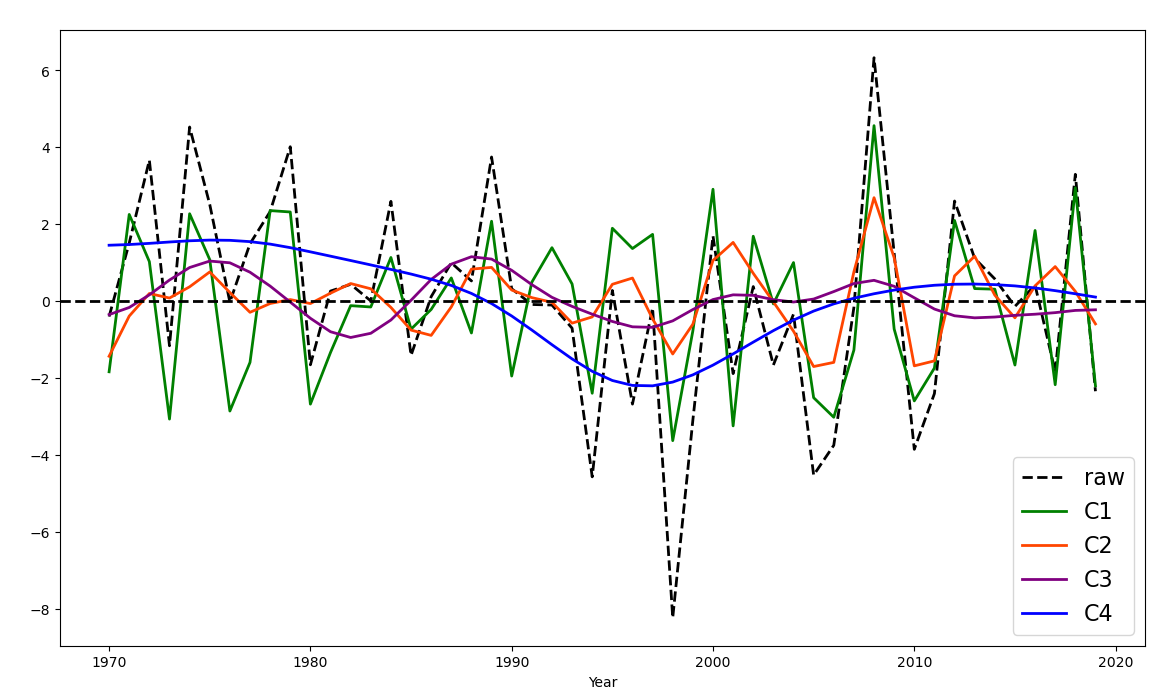

In [8]:
x = t
spg = hind_eemd_9
y1 = spg[0,:]
y2 = spg[1,:]
y3 = spg[2,:]
y4 = spg[3,:]
y5 = spg[4,:]

fig, ax = plt.subplots(figsize = [14,8])
# ax.plot(x, y0, '-', linestyle='dashed', color='black', linewidth=2, markersize=10, label = 'raw')
ax.plot(x, y1, '-', color='black', linestyle='dashed', linewidth=2, markersize=10, label = 'raw')
ax.plot(x, y2, 'g-', linewidth=2, markersize=10, label = 'C1')
ax.plot(x, y3, '-', color='orangered', linewidth=2, markersize=10, label = 'C2')
ax.plot(x, y4, '-', color='purple', linewidth=2, markersize=10, label = 'C3')
ax.plot(x, y5, '-', color='blue', linewidth=2, markersize=10, label = 'C4')


ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')
ax.set(xlabel='Year', ylabel=' ',
       title=' ')
# ax.set_ylim(-0.1, 1.1)
# ax.grid()
ax.legend(loc='lower right', fontsize='16')
# ax.annotate('5%', fontsize='16',
#             xy=(80, 150), xycoords='figure points')

plt.rcParams["font.size"] = "20"
plt.show()